# Pass heat maps

Make a heat map of all teams passes during a tournament. In order to add context, we set a window for danger passes to be those in 15 seconds leading up to a shot

First let's open the dataset, we want all of the England Womens team games, if they played home or away. We also calculate total games so we can normalize the data later on.

In [1]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen, VerticalPitch
import pandas as pd

#open the data
parser = Sbopen()
df_match = parser.match(competition_id=72, season_id=30)
#our team
team = "England Women's"
#get list of games by our team, either home or away
match_ids = df_match.loc[(df_match["home_team_name"] == team) | (df_match["away_team_name"] == team)]["match_id"].tolist()
#calculate number of games
no_games = len(match_ids)

## Finding danger passes

A `danger pass` is a pass that took place 15s before a shot took place.

- First, for each game using mplsoccer parser we open the event data. Note that we use the [0] to store only event data. 

- Then, for each period in the game we take out shots by England and accurate passes by England that were not set pieces. 

- We look for the passes 15 seconds before a shot. That is why we iterate for different periods. If a shot was made in 46th minute and there were 3 additional minutes in the first half, we would include those passes. Having the danger passes we concatenate them with a pandas dataframe to store danger passes from all games

In [3]:
# create an empty dataframe
danger_passes = pd.DataFrame()

# go through each match ID
for idx in match_ids:
    # open the event data for this game [0]
    df = parser.event(idx)[0]
    # this is for either half of the match
    for period in [1,2]:
        # keep only accurate passes by England that were not set pieces in this period
        mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
        # keep only the columns that we want
        passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]
        # keep only England shots in this period
        mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period)
        # again keep only columns we want, this case only when the shot was taken
        shots = df.loc[mask_shot, ["minute", "second"]]
        # convert time to seconds
        shot_times = shots['minute']*60+shots['second']
        shot_window = 15
        # find start of the time window and have condition to avoid negative shot starts
        shot_start = shot_times - shot_window
        shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
        # convert pass times to seconds
        pass_times = passes['minute']*60+passes['second']
        #check if pass is in any of the windows, shot_start should be < pass_time if 15s is taken from it and its in the window
        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

        #keep only danger passes
        danger_passes_period = passes.loc[pass_to_shot]
        #concatenate dataframe with a previous one to keep danger passes from the whole tournament
        danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)


## Plotting location of danger passes
First, we create a pitch using mplsoccer Pitch class. Then we scatter them using scatter method

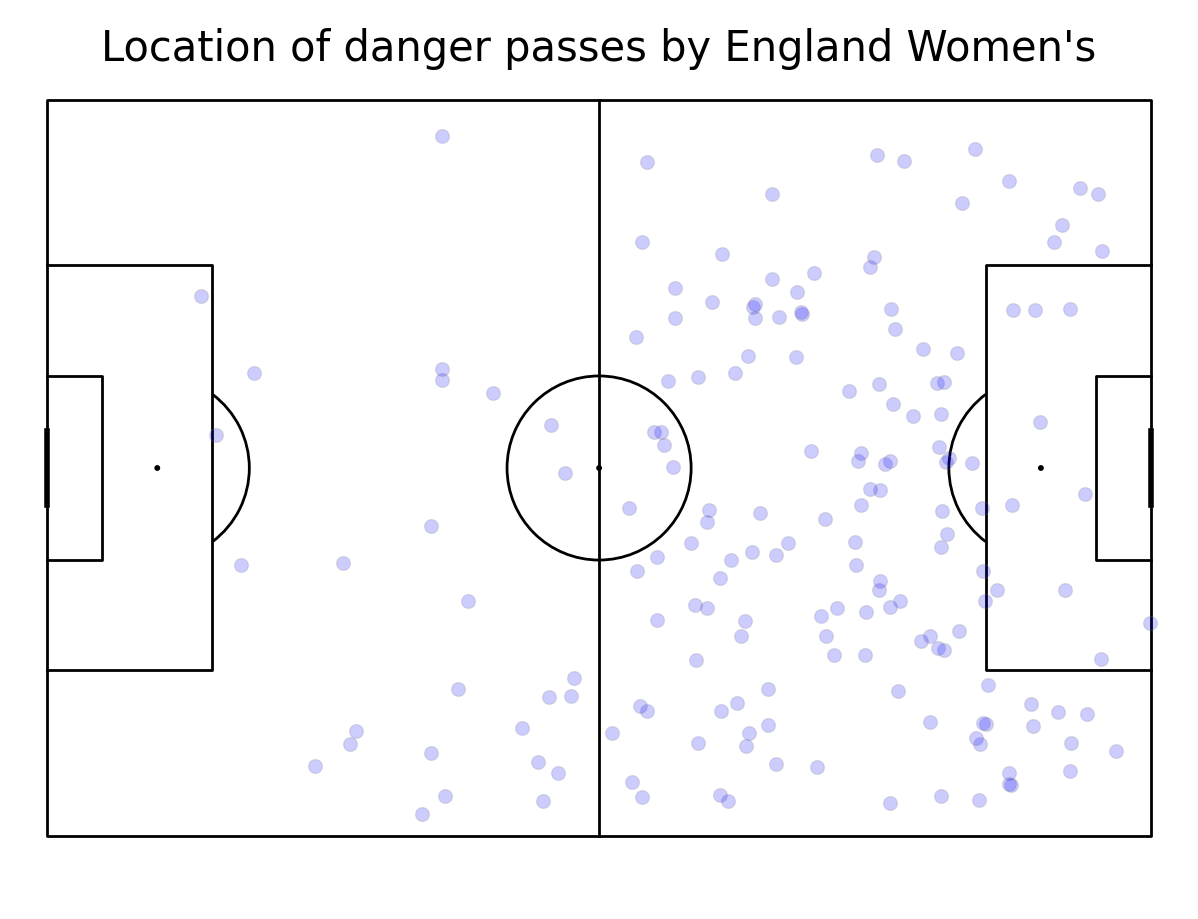

In [4]:
#plot pitch
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#scatter the location on the pitch
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax["pitch"])
#uncomment it to plot arrows
#pitch.arrows(danger_passes.x, danger_passes.y, danger_passes.end_x, danger_passes.end_y, color = "blue", ax=ax['pitch'])
#add title
fig.suptitle('Location of danger passes by ' + team, fontsize = 30)
plt.show()

## Making a heat map

To get a heat map, we need to calculate the number of danger passes in bins using `bin_statistic`. The bins are the number of grids.

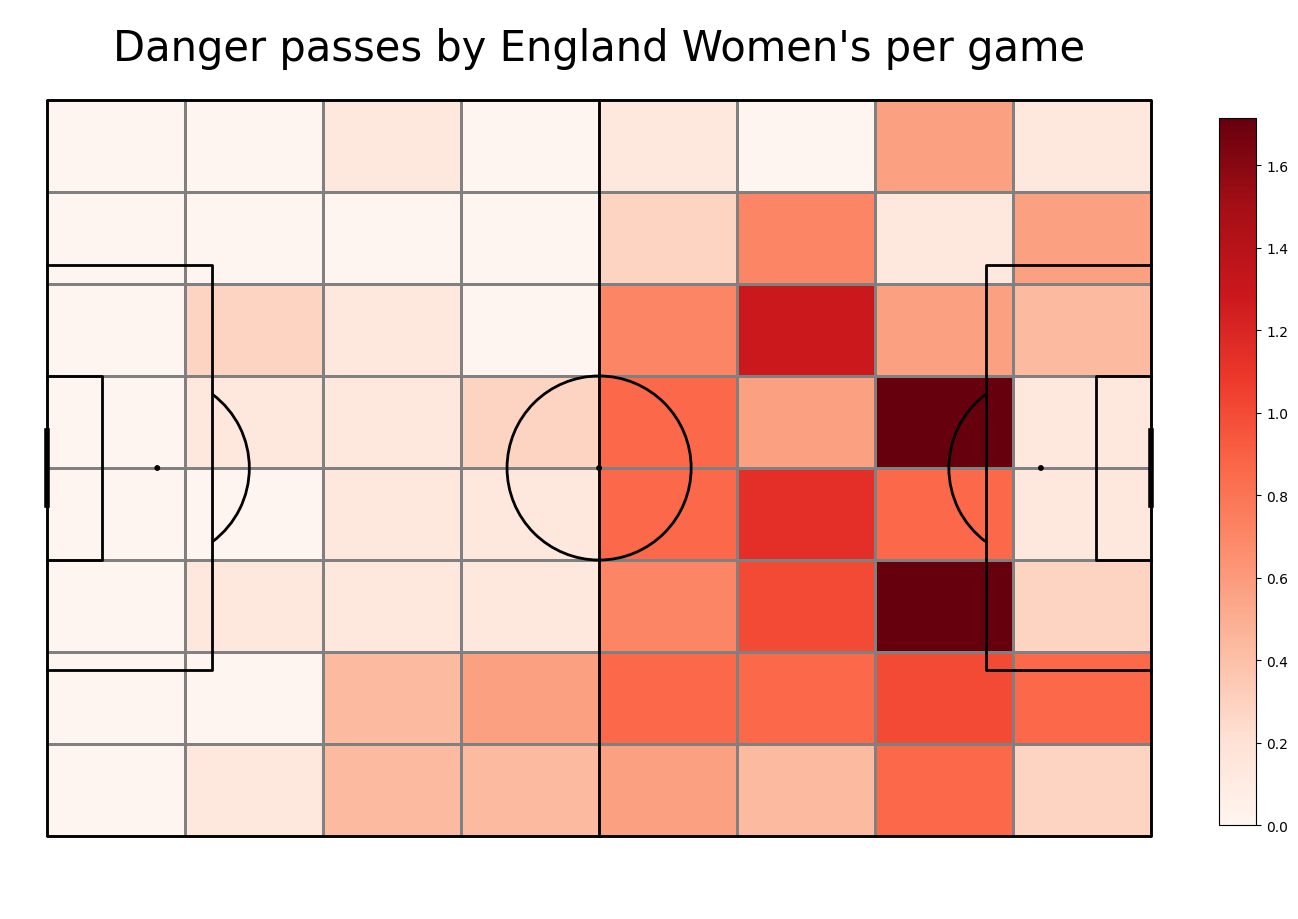

In [8]:
#plot vertical pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#get the 2D histogram
bin_statistic = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic='count', bins=(8, 8), normalize=False)
#normalize by number of games
bin_statistic["statistic"] = bin_statistic["statistic"]/no_games
#make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes by ' + team + " per game", fontsize = 30)
plt.show()

## Number of danger passes per game

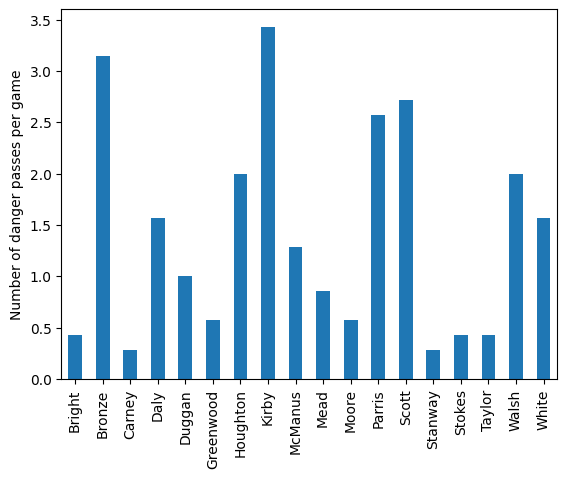

In [9]:
#keep only surnames
danger_passes["player_name"] = danger_passes["player_name"].apply(lambda x: str(x).split()[-1])
#count passes by player and normalize them
pass_count = danger_passes.groupby(["player_name"]).x.count()/no_games
#make a histogram
ax = pass_count.plot.bar(pass_count)
#make legend
ax.set_xlabel("")
ax.set_ylabel("Number of danger passes per game")
plt.show()